In [1]:
import os
os.chdir("F://!BENTLEY//RA//SIR") 

In [2]:
import numpy as np
import pandas as pd
from math import *

## sir

In [3]:
def matpower(a, alpha):
    '''
    Parameters
    ----------
    a : a symmetirc matrix
    alpha : num

    Returns
    -------
    re : the alpha power of a symmetric matrix a
    '''
    a = np.around((a + a.T)/2,7)
    values, vectors = sorted_eig(a)
    re = (vectors.dot(np.diag(values**alpha))).dot(vectors.T)
    return re

def discretize(y, h):
    '''
    Parameters
    ----------
    y : the original sample of response
    h : the number of slices

    Returns
    -------
    y1: the code divides the sample of y roughly evenly
    '''
    n = len(y)
    m = int(np.floor(n/h))
    y = y+.00001*np.mean(y)*np.random.randn(n)  # to get the true y
    yord = np.sort(y)
    divpt = []
    for i in range(1,h):  #1,2,3,..,h-1
        divpt = np.append(divpt,yord[i*m])
    
    #get y1 in 1 to h 
    
    y1 = np.zeros((n,1))
    y1[y < divpt[0]] = 1
    y1[y >= divpt[h-2]]=h
    
    for i in range(1,h-1):
        y1[(y>=divpt[i-1])&(y<divpt[i])]=i+1
    
    return y1


def sir(x,y,h,r,ytype):
    '''
    Parameters
    ----------
    x : a matrix of dimension nxp
    y : the original sample of response
    h : the number of slices
    r : the dimension of sir
    ytype : data type of y, 'continuous' or 'categorical'

    Returns
    -------
    computes the vectors beta_1, beta_2,...,beta_r
    '''
    n,p = x.shape
    #standardize x
    signrt = matpower(np.cov(x,rowvar = False), -1/2) #(p,p)
    xc = (x.T - np.mean(x,axis=0).reshape(p,1)).T #(n,p)
    xst = xc.dot(signrt) #(n,p)
    
    if (ytype=='continuous'):
        ydis = discretize(y, h)
    if(ytype=='categorical'):
        ydis = y
    
    #label y
    yless = ydis
    ylabel = []
    
    for i in range(n):
        if np.var(yless) != 0:
            ylabel = np.append(ylabel,yless[0])
            yless = yless[yless!=yless[0]]
            
    ylabel = np.append(ylabel,yless[0])
    prob = np.zeros((h,1))
    exy = np.zeros((h,p))
    
    #probility for each h pack
    for i in range(h):
        prob[i] = len(ydis[ydis==ylabel[i]])/n
    
    #conditional mean of X in each h pack
    for i in range(h):
        mat = xst[np.where(ydis==ylabel[i])[0]] #(?,p)
        exy[i,:] = np.mean(mat, axis = 0) #(p,n)
        
    sirmat = ((exy.T).dot(np.diag(prob.flatten()))).dot(exy)  #Exy.T * D * Exy
    
    #eigen decomposition
    values,vectors = sorted_eig(sirmat)  
    
    #r stands for the dimension of the true spaces,
    #h stands for h directions in the spaces
    #eigen vectors are orthogonal
    return signrt.dot(vectors[:,0:r])

def sorted_eig(mat): #descending
    values,vectors = np.linalg.eigh(mat) 
    idx = values.argsort()[::-1]   
    values = values[idx]
    vectors = vectors[:,idx]  ##ith eign value - ith col vector
    
    return values, vectors

In [4]:
df =pd.read_excel('bigmacindex.xlsx', sheet_name=1, header=0).iloc[:,0:10]
y = np.array(df.iloc[:,9])
x = np.array(df.iloc[:,0:9])

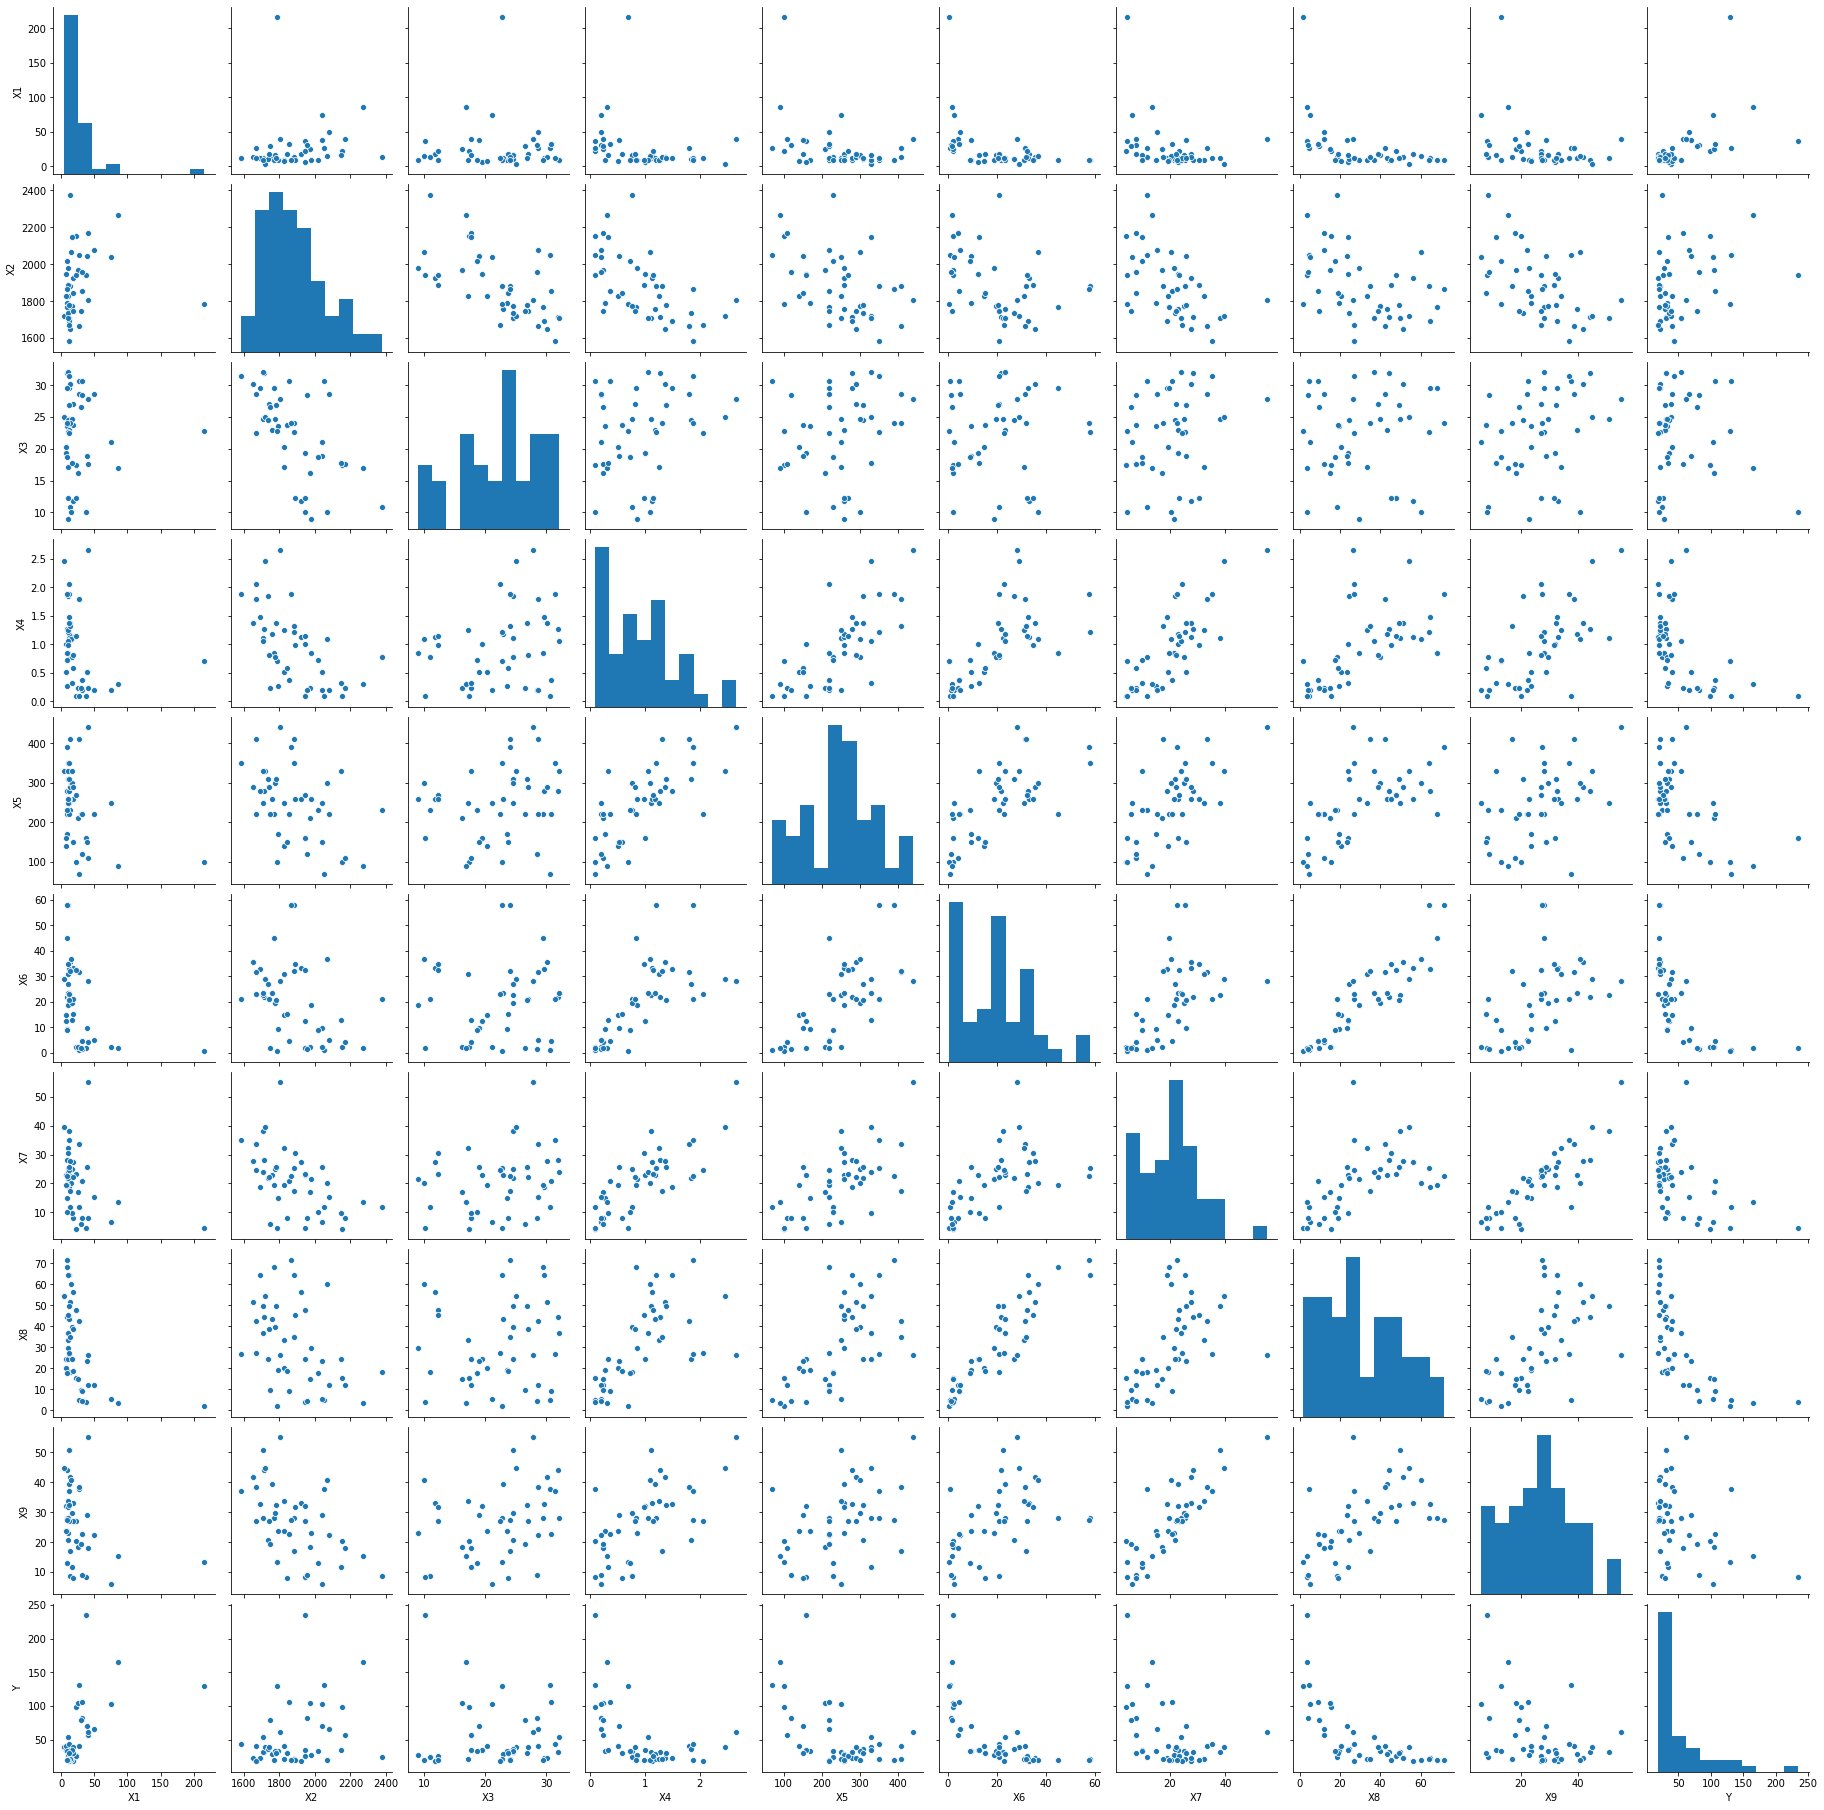

In [7]:
import seaborn as sns
sns.pairplot(df)

In [8]:
h=8
r=2
ytype = 'continuous'

beta = sir(np.array(x),np.array(y),h,r,ytype)
sirPre1 = np.dot(x,beta[:,0])
sirPre2 = np.dot(x,beta[:,1])

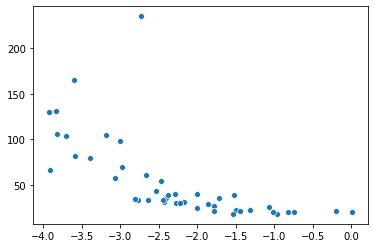

In [9]:
sns.scatterplot(sirPre1,y)

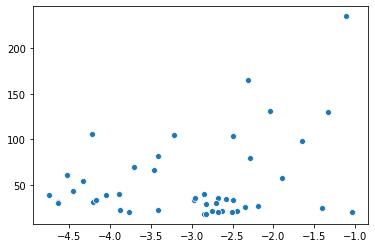

In [10]:
sns.scatterplot(sirPre2,y)

In [11]:
#spearman corr
df.corr('spearman').iloc[:,9]

X1    0.606698
X2    0.237745
X3    0.158776
X4   -0.606991
X5   -0.456551
X6   -0.827422
X7   -0.426358
X8   -0.797323
X9   -0.347882
Y     1.000000
Name: Y, dtype: float64

In [12]:
pd.Series(sirPre1).corr(pd.Series(y), method = 'spearman')

-0.8906252787218026

In [13]:
pd.Series(sirPre2).corr(pd.Series(y), method = 'spearman')

0.028217308408685433

## pir

In [14]:
def pir(x,y,m,r):
    n,p = x.shape
    xc = (x.T - np.mean(x,axis=0).reshape(p,1)).T 
    signrt = matpower(np.cov(x,rowvar = False),-1/2)
    xstand = xc.dot(signrt)
    f = np.zeros((n,m))
    ystand = (y-np.mean(y))/np.std(y, ddof=1) #uses denominator n - 1
    for i in range(m):
        f[:,i] = ystand**(i+1)
    
    sigxf = np.cov(xstand,f,rowvar=False)[-m:,0:p].T
    sigff = np.cov(f,rowvar = False)
    cand = sigxf.dot(np.linalg.inv(sigff)).dot(sigxf.T)
    
    _,vectors = sorted_eig(cand)  
    beta = signrt.dot(vectors[:,0:r])
    return beta

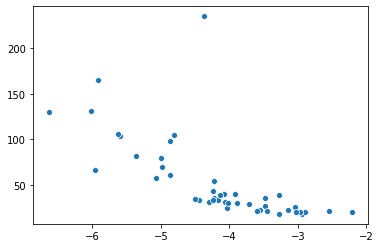

In [15]:
m=3
r=2
beta = pir(x,y,m,r)
pirPre1 = x.dot(beta[:,0])
sns.scatterplot(pirPre1,y)

In [16]:
pd.Series(pirPre1).corr(pd.Series(y), method = 'spearman')

-0.8857465852118896

## kir

In [17]:
# kir--------------------------
def kir(x,y,b,eps,r):
    def gker(b,y):
        n=len(y)
        y = y.reshape(-1,1)
        k1 = y.dot(y.T)
        k2 = np.tile(np.diag(k1),(n,1)).T
        return (1/b)*np.exp(-(k2+k2.T-2*k1)/(2*b**2))
        
    n,p=x.shape
    xc = (x.T - np.mean(x,axis=0).reshape(p,1)).T 
    signrt = matpower(np.cov(x,rowvar = False),-1/2)
    xst = xc.dot(signrt) #(n,p)  #standarize
    #f = np.zeros((n,m))
    yst = (y-np.mean(y))/np.std(y, ddof=1) #uses denominator n - 1
    kern=gker(b,yst)  #(n,n)
    
    one = np.ones((45,1))
    mea=np.mean(kern.dot(one))
    den = np.max(np.hstack((kern.dot(one),eps*mea*one)),1)
    scale = sorted_eig(kern)[0][0]
    exy = kern.dot(xst)*(1/den.reshape(-1,1))
    mat = np.dot(exy.T,exy)
    _,vectors = sorted_eig(mat)
    return signrt.dot(vectors[:,0:r])


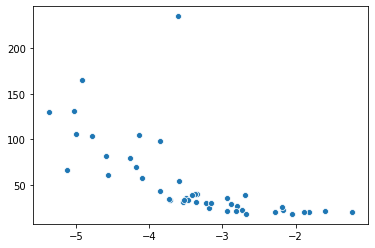

In [18]:
b = 0.2
eps = 1.1
r=2
beta = kir(x,y,b,eps,r)
kirPre1 = x.dot(beta[:,0])
kirPre2 = x.dot(beta[:,1])
sns.scatterplot(kirPre1,y)

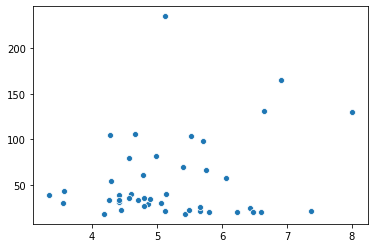

In [19]:
sns.scatterplot(kirPre2,y)

In [20]:
pd.Series(kirPre1).corr(pd.Series(y), method = 'spearman')

-0.897415892661276

In [21]:
pd.Series(kirPre2).corr(pd.Series(y), method = 'spearman')

-0.04792986732036053